In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pandas_ta as ta
import skfuzzy as fuzz
import seaborn as sns
from fuzzy_expert.rule import FuzzyRule
from fuzzy_expert.variable import FuzzyVariable
from fuzzy_expert.inference import DecompositionalInference
from pygad import GA
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#EDA

def read_series(name:str):
    folder = os.path.join(os.getcwd(), 'time_series')
    return pd.read_csv(folder + f'/{name}_weekly.csv')

list_series = ['American Express','AMGEN','Apple','Chevron', 'CISCO',  '3M']
list_stocks = [read_series(i) for i in list_series]

for i in range(len(list_stocks)):
    for j in range(len(list_series)):
        if i == j:
            print(f"Stock: {list_series[j]}")
            print(list_stocks[i].head())
            print('Null Values:', list_stocks[i].isnull().sum())
            print('Shape:',list_stocks[i].shape)


Stock: American Express
         Date    Open    High     Low   Close   Volume
0  1993-11-28  31.125  31.125  30.750  5.2557   236100
1  1993-12-05  31.000  32.375  30.875  5.3614  3741800
2  1993-12-12  31.875  32.375  31.000  5.3404  3933100
3  1993-12-19  31.250  32.000  30.000  5.1497  7075300
4  1993-12-26  30.625  31.625  30.500  5.3194  4654200
Null Values: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Shape: (1566, 6)
Stock: AMGEN
         Date   Open   High    Low   Close   Volume
0  1993-11-28  44.75  45.75  44.50  4.5708   579500
1  1993-12-05  45.25  47.25  44.50  4.7729  5051200
2  1993-12-12  46.75  47.25  43.75  4.4444  5447200
3  1993-12-19  44.25  45.25  44.00  4.5454  3116000
4  1993-12-26  45.25  46.75  44.25  4.6970  3761200
Null Values: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Shape: (1566, 6)
Stock: Apple
         Date   Open    High    Low   Close   Volume
0  1993-11-28  32.75  33.

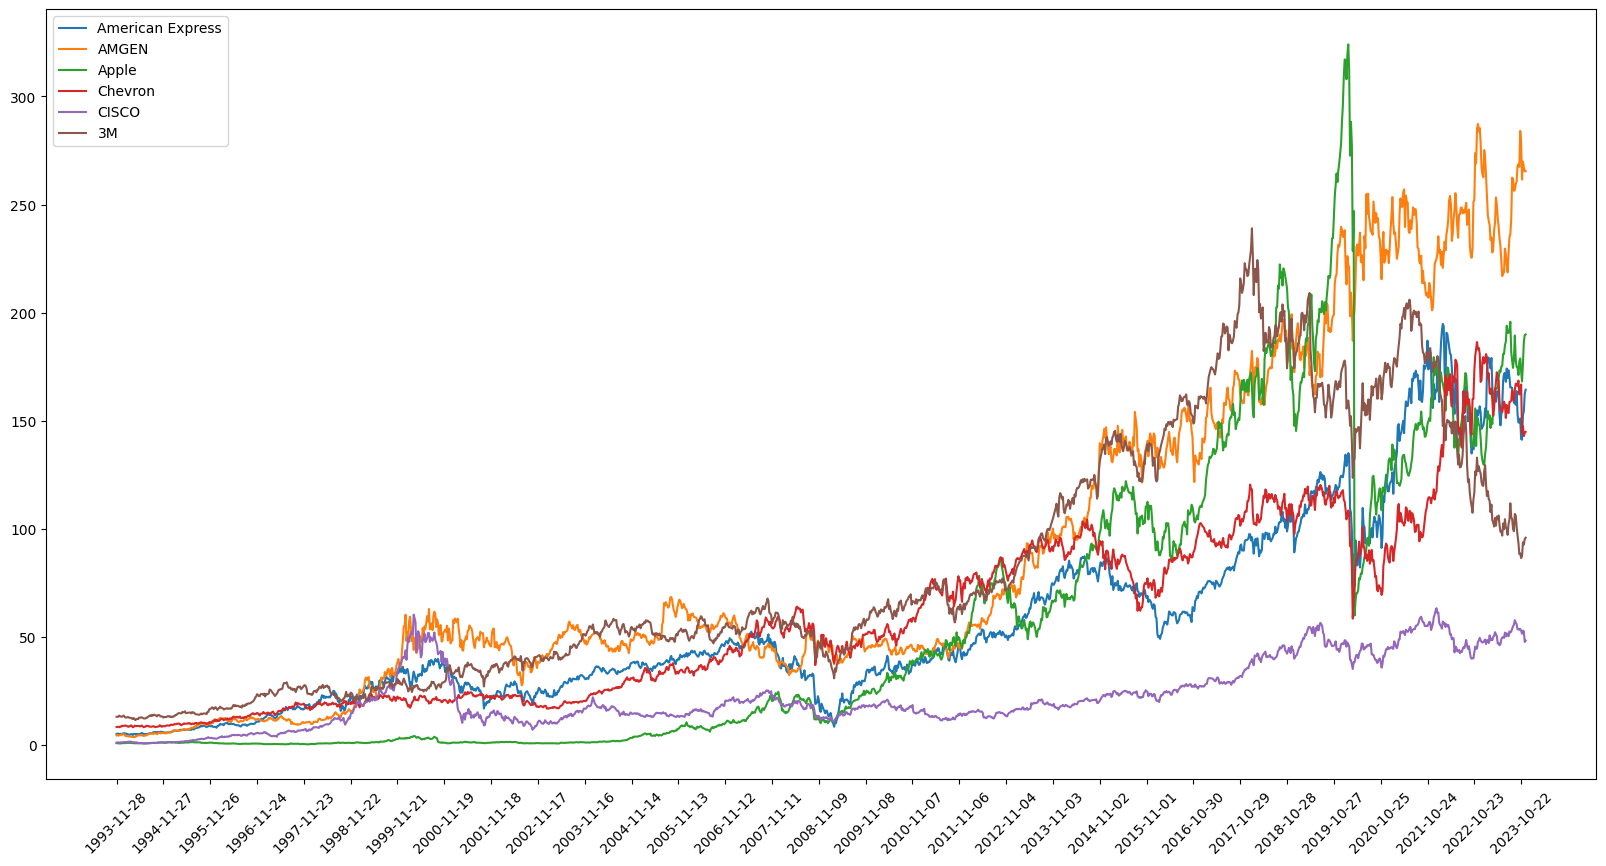

In [3]:
#time plot of every stock in an unique plot, do a legend with different colors for each stock
plt.figure(figsize=(20, 10))

# Plotting all data points
for i in range(len(list_stocks)):
    plt.plot(list_stocks[i]['Date'], list_stocks[i]['Close'], label=list_series[i])

# Customize x-ticks to show only 20% of the dates
dates = list_stocks[0]['Date']
total_dates = len(dates)
step = total_dates // 30  

plt.xticks(dates[::step], rotation=45)

plt.legend()
plt.show()



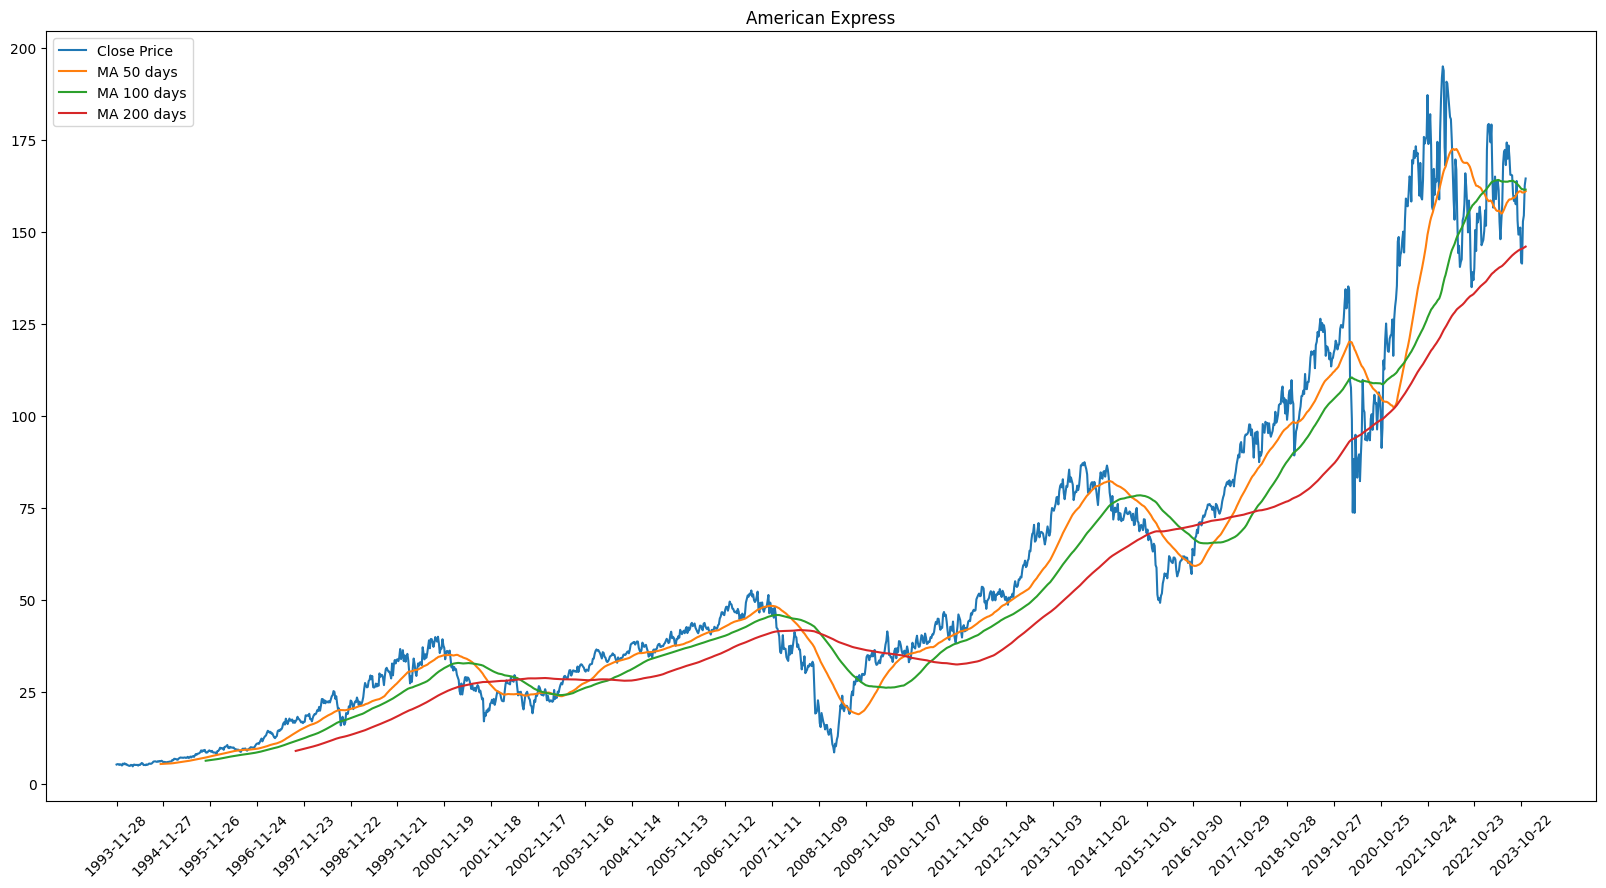

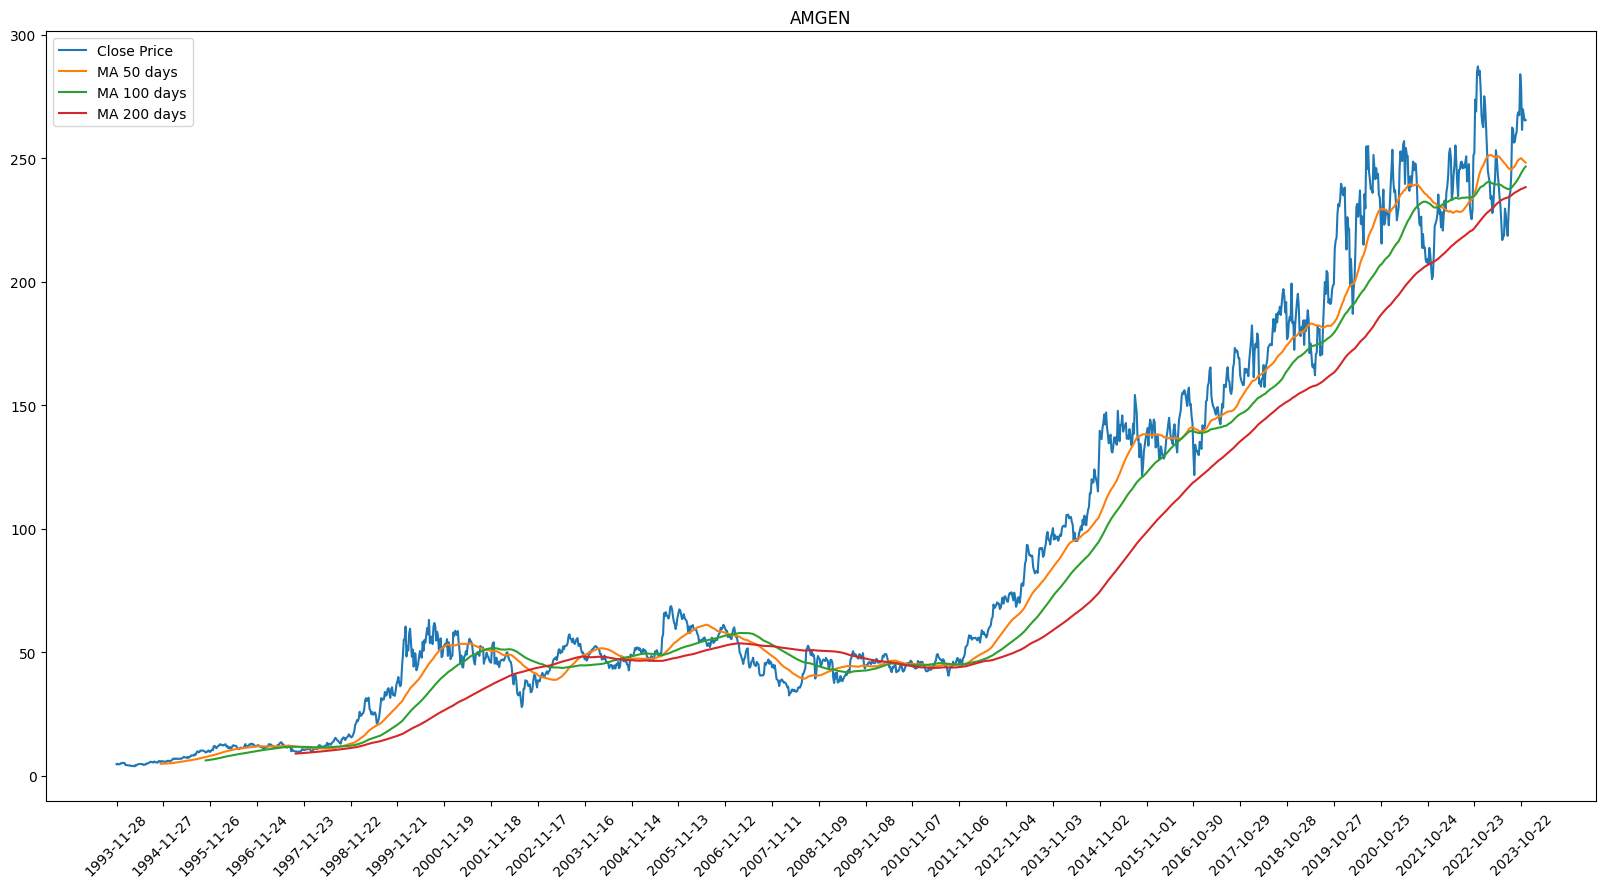

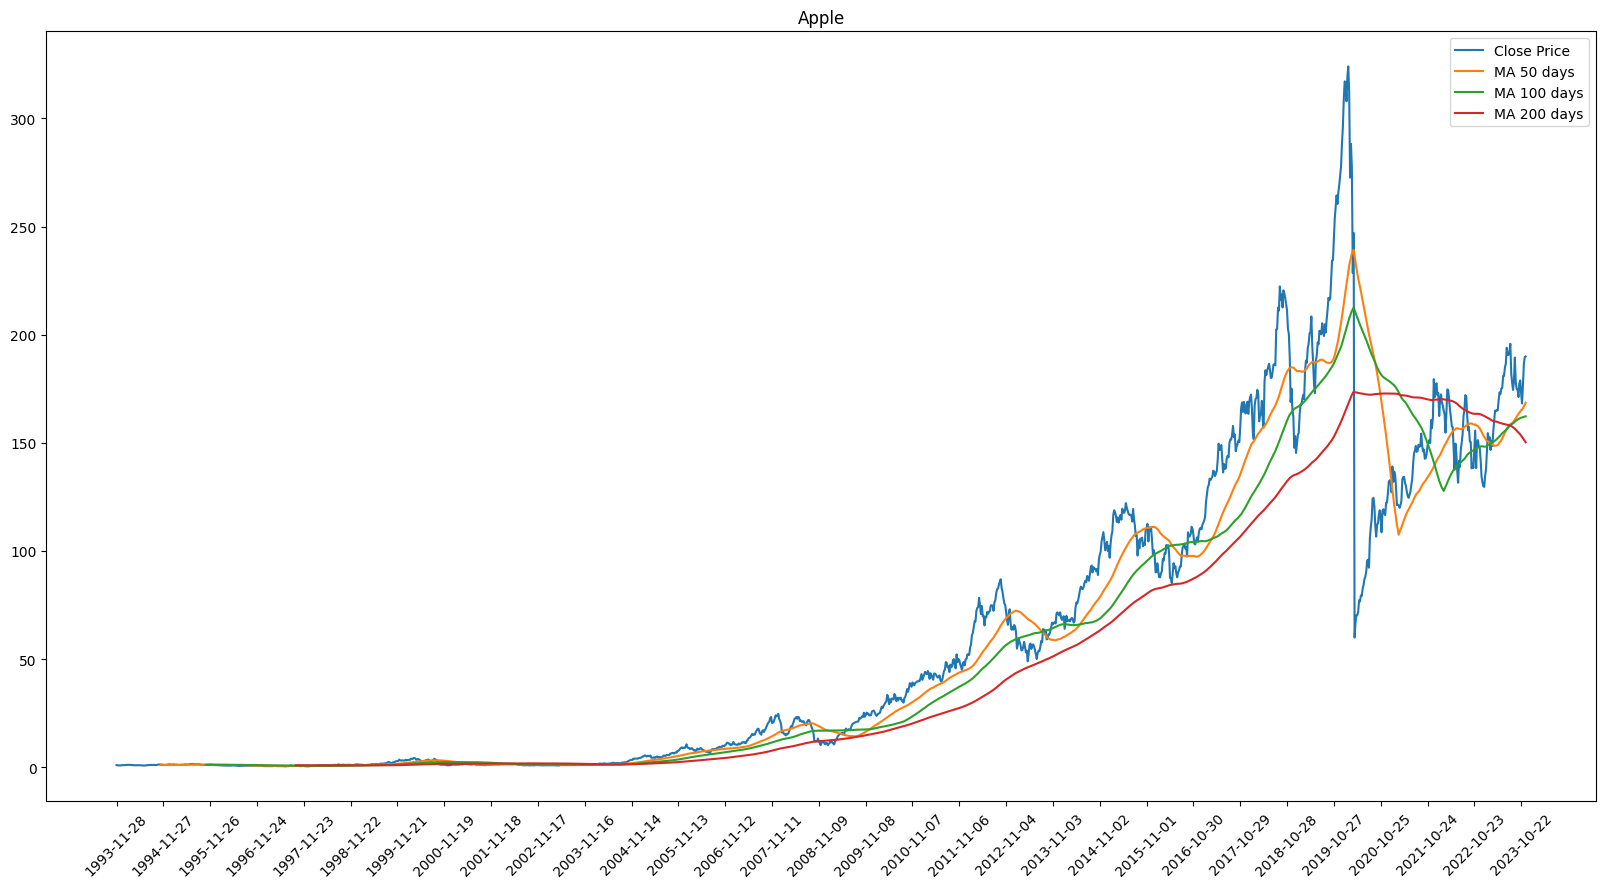

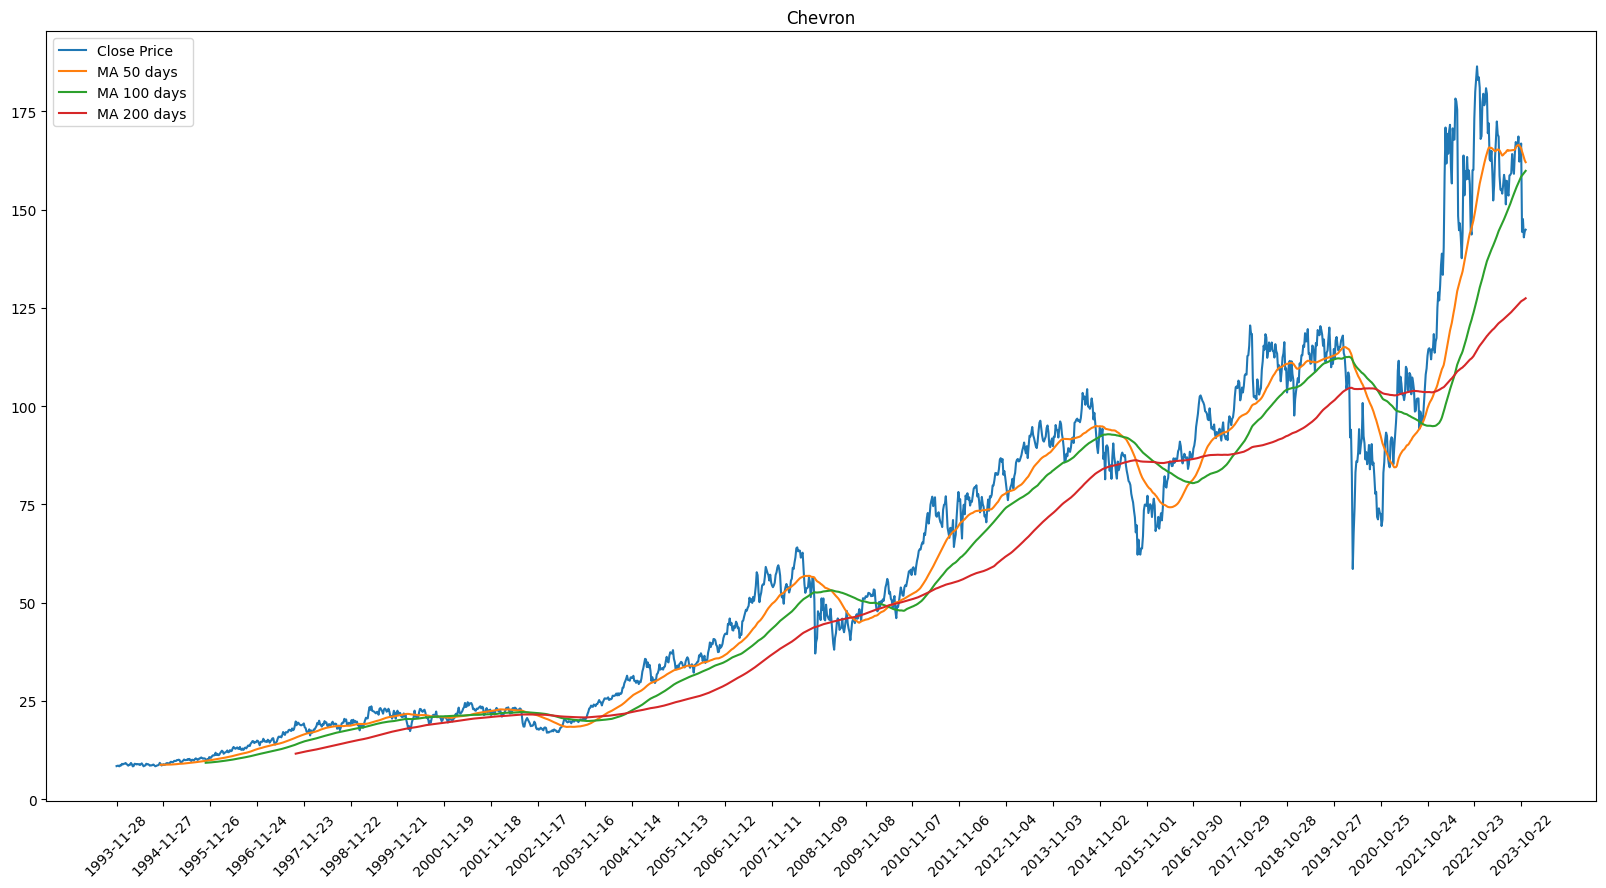

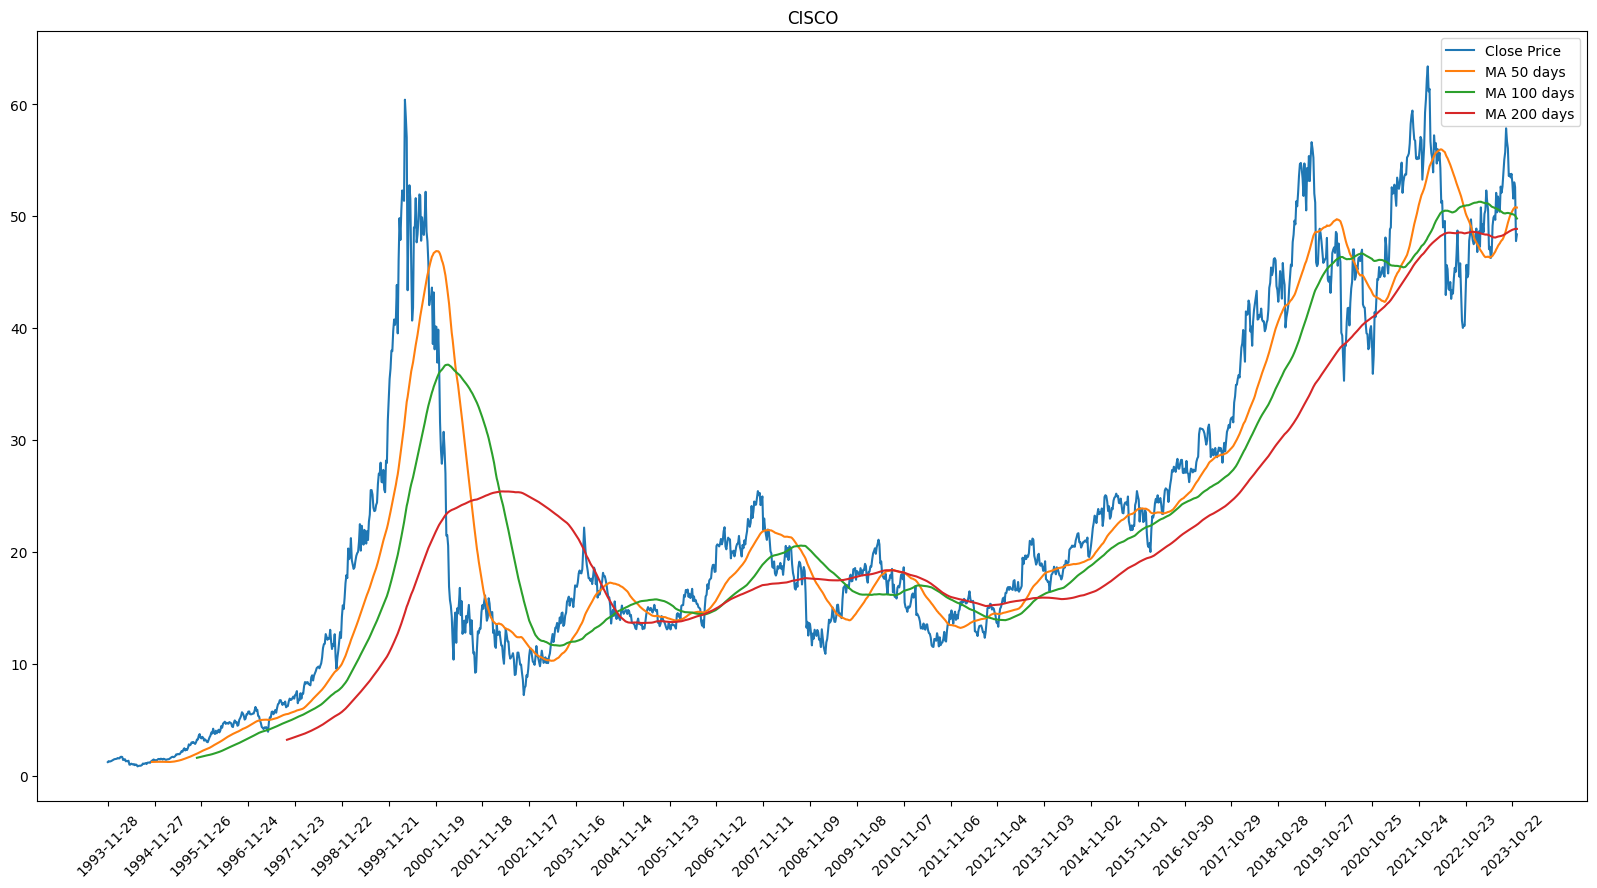

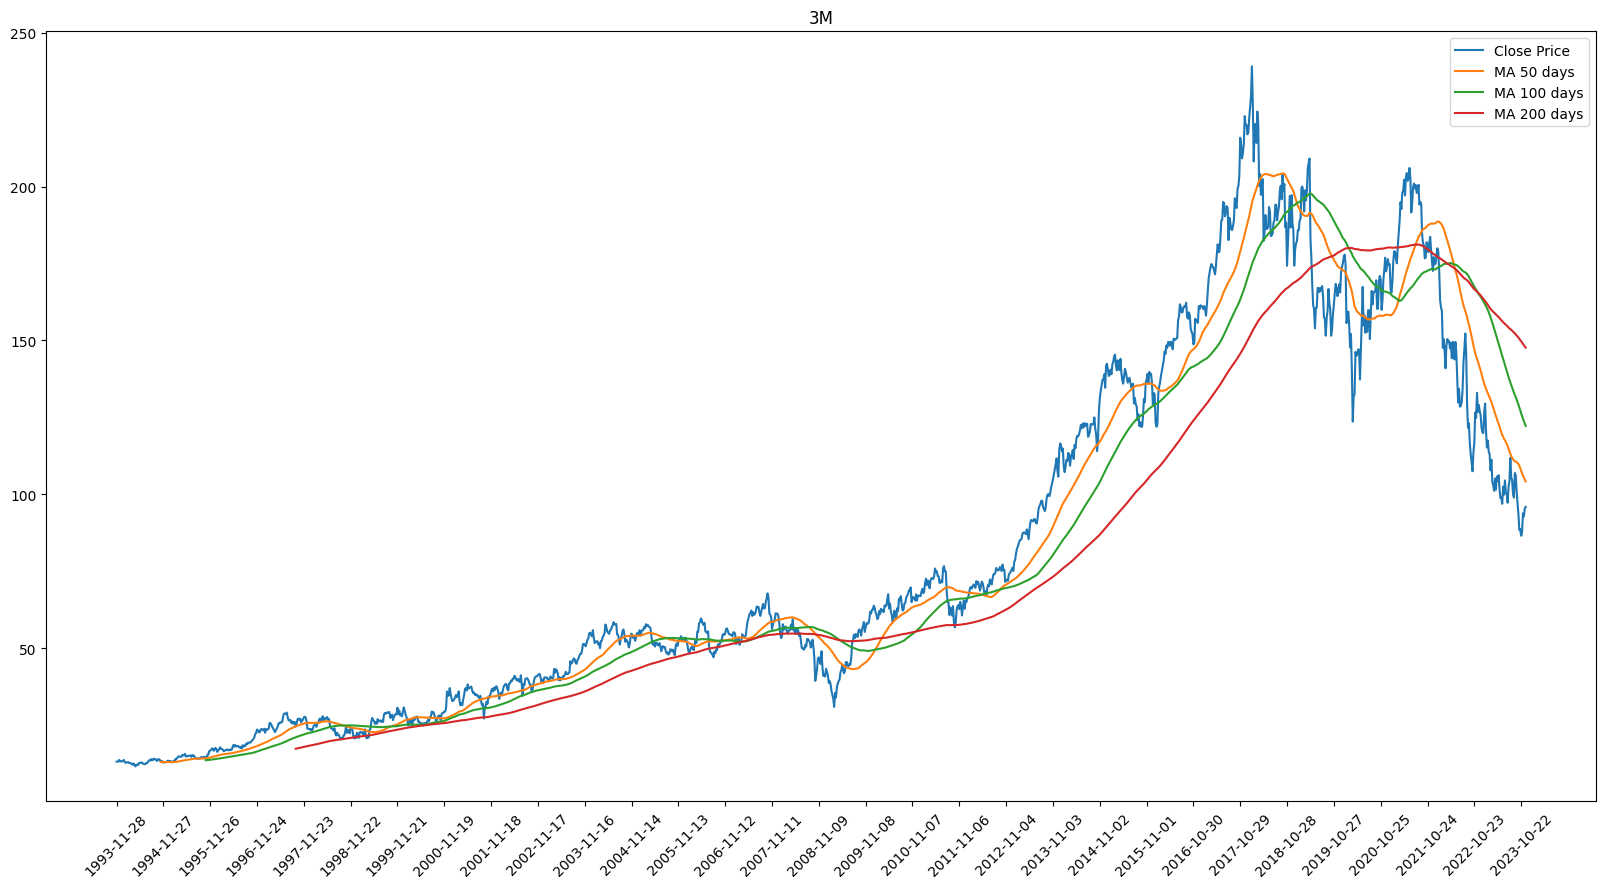

In [4]:
#calculating the moving average of the close price for each stock with lag of 50, 100, 200 days
for i in range(len(list_stocks)):
    list_stocks[i]['MA_50'] = list_stocks[i]['Close'].rolling(window=50).mean()
    list_stocks[i]['MA_100'] = list_stocks[i]['Close'].rolling(window=100).mean()
    list_stocks[i]['MA_200'] = list_stocks[i]['Close'].rolling(window=200).mean()

#plotting the moving average of the close price for each stock with lag of 50, 100, 200 days, one plot per stock

for i in range(len(list_stocks)):
    plt.figure(figsize=(20, 10))

    plt.plot(list_stocks[i]['Date'], list_stocks[i]['Close'], label='Close Price')
    plt.plot(list_stocks[i]['Date'], list_stocks[i]['MA_50'], label='MA 50 days')
    plt.plot(list_stocks[i]['Date'], list_stocks[i]['MA_100'], label='MA 100 days')
    plt.plot(list_stocks[i]['Date'], list_stocks[i]['MA_200'], label='MA 200 days')
    plt.title(list_series[i])
    dates = list_stocks[0]['Date']
    total_dates = len(dates)
    step = total_dates // 30  

    plt.xticks(dates[::step], rotation=45)
    plt.legend()
    plt.show()



/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/pand

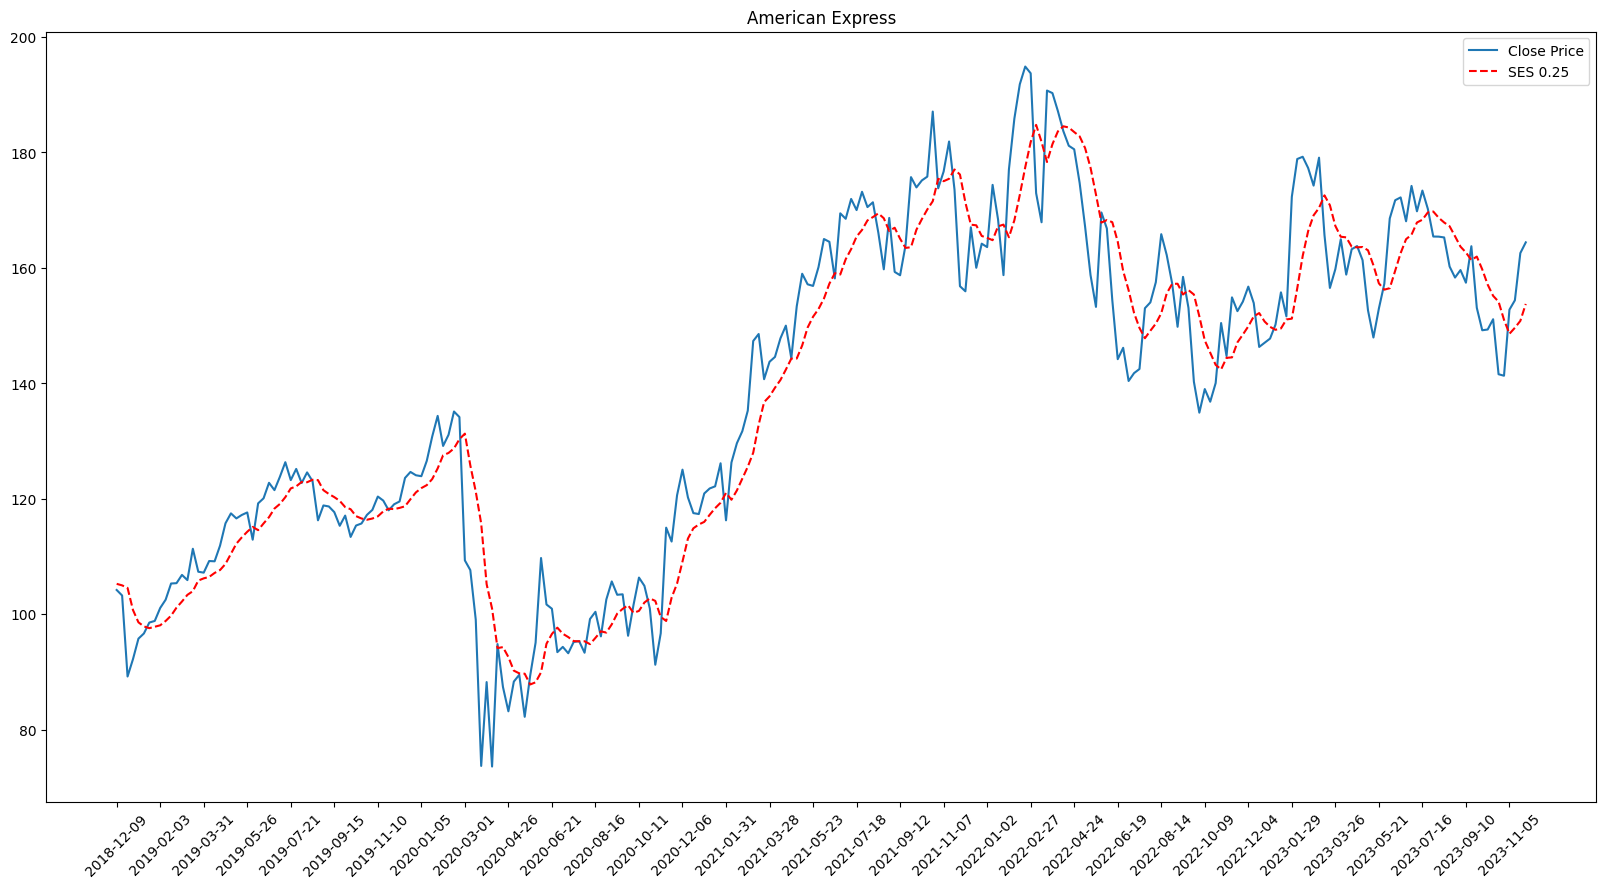

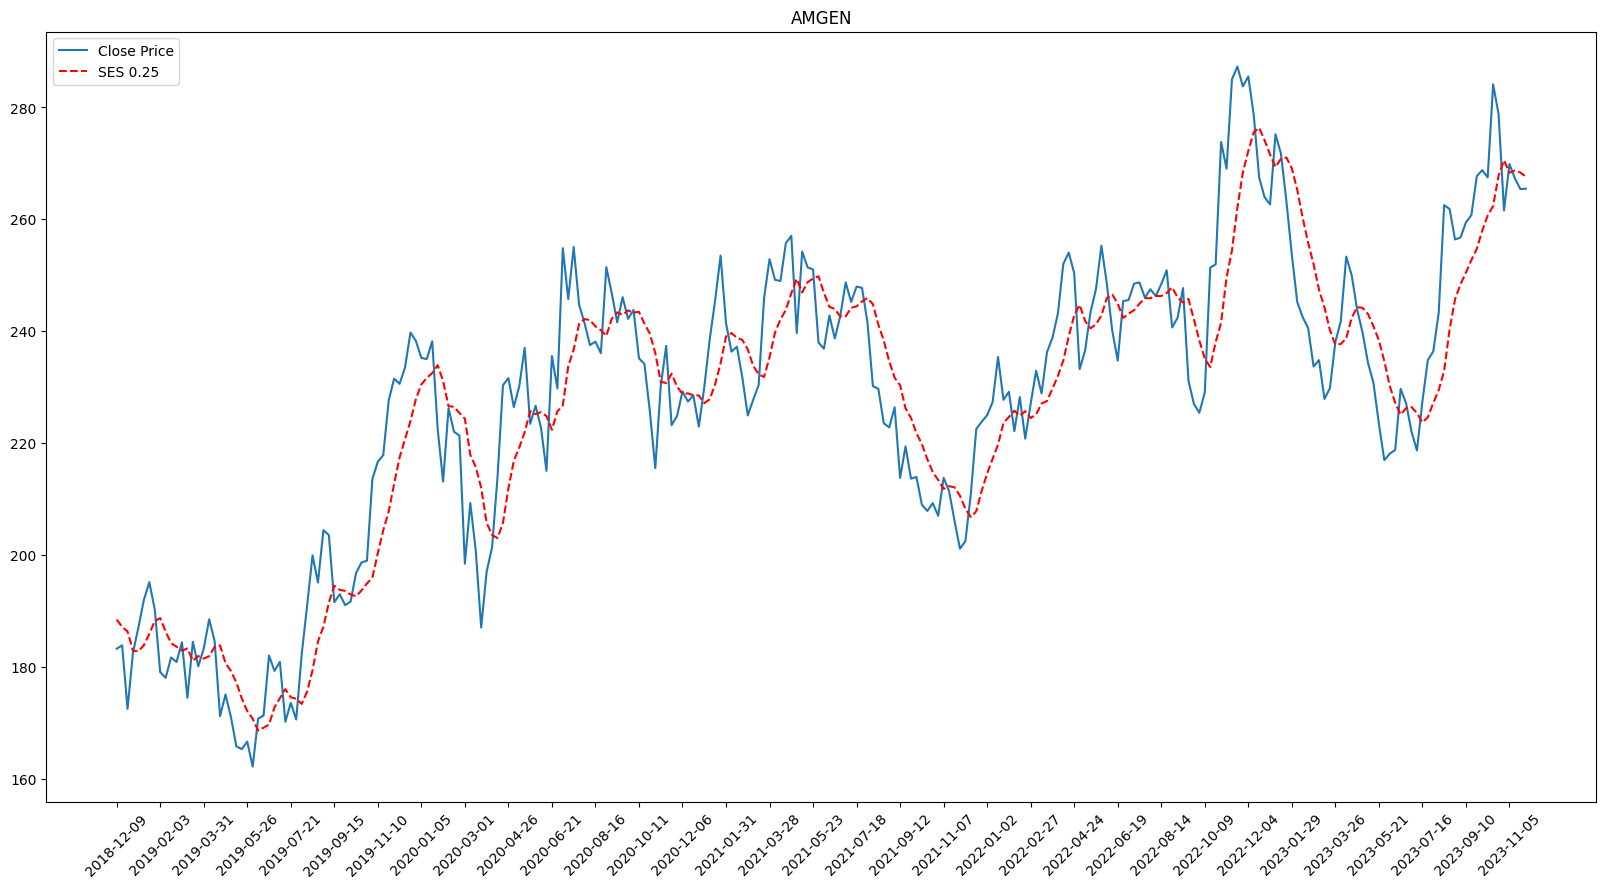

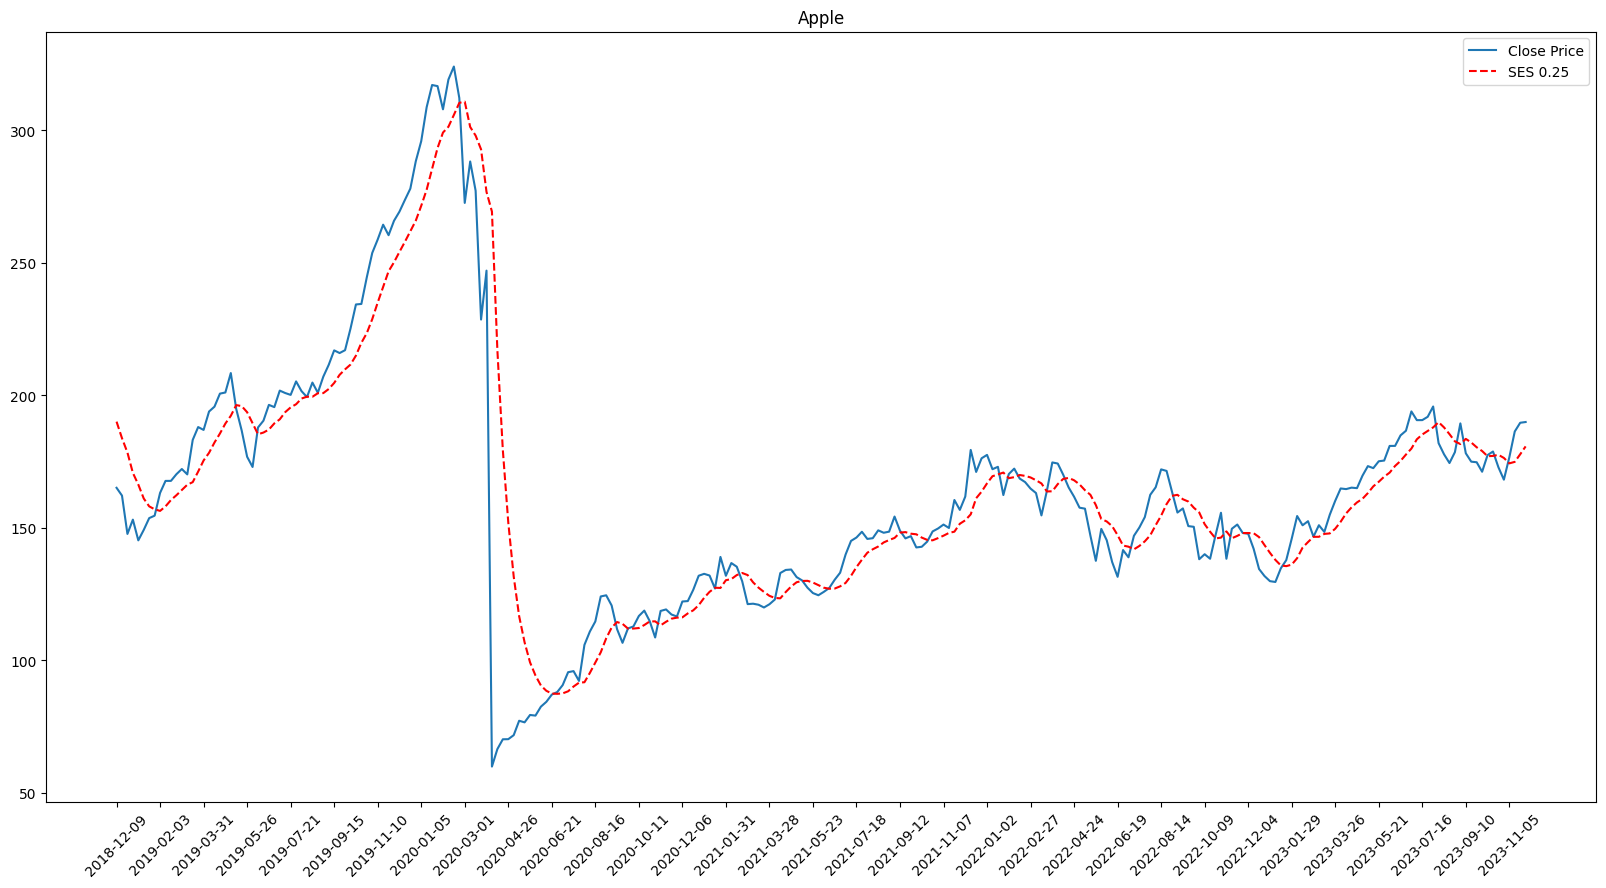

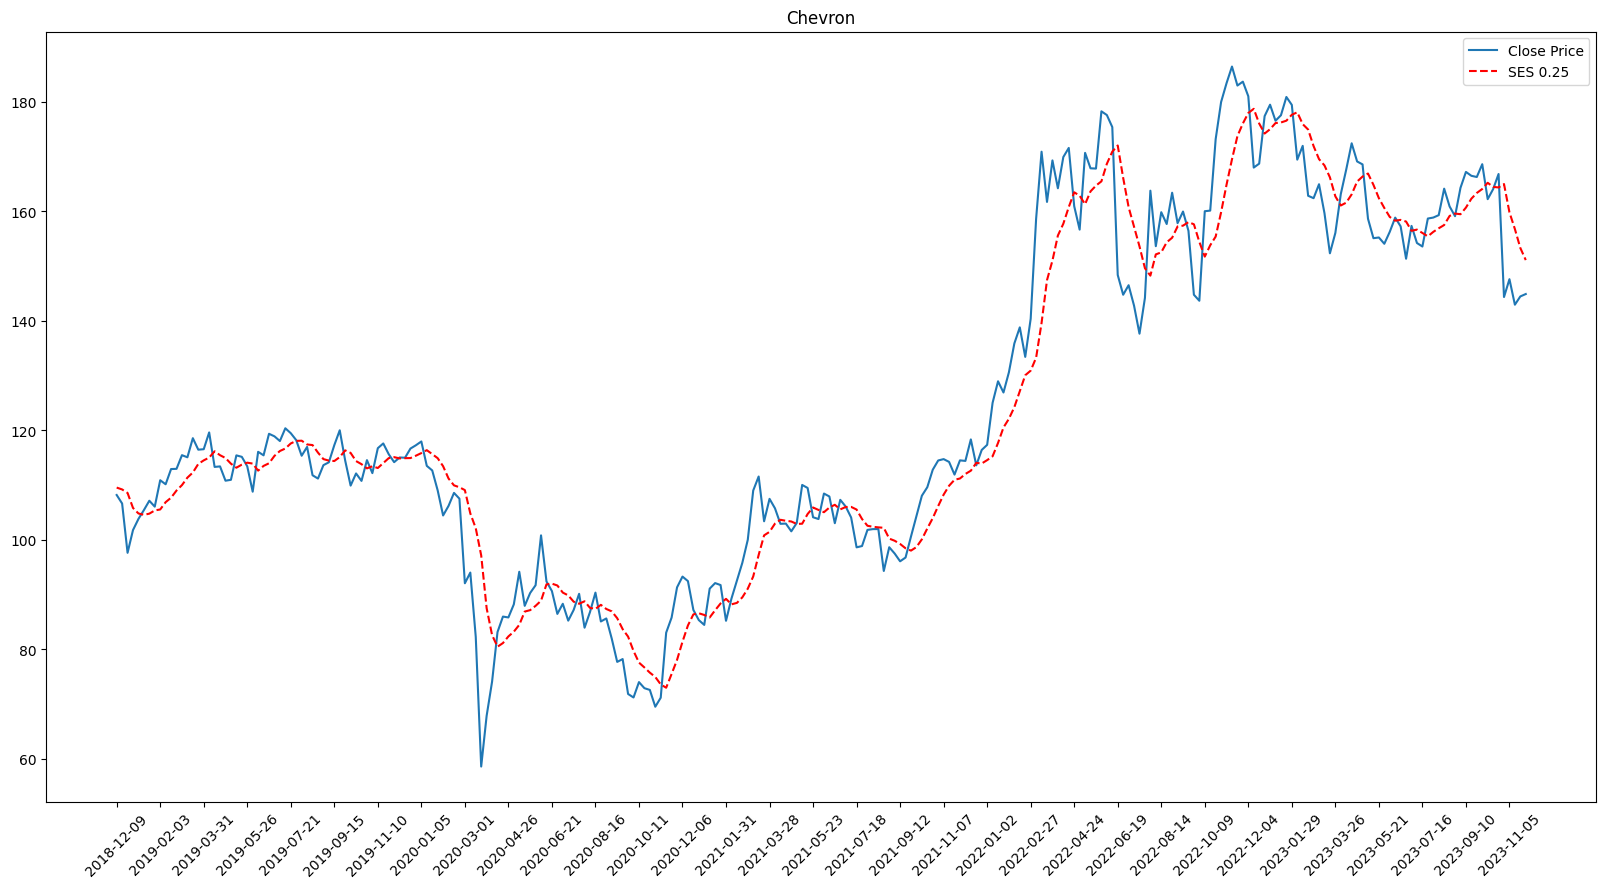

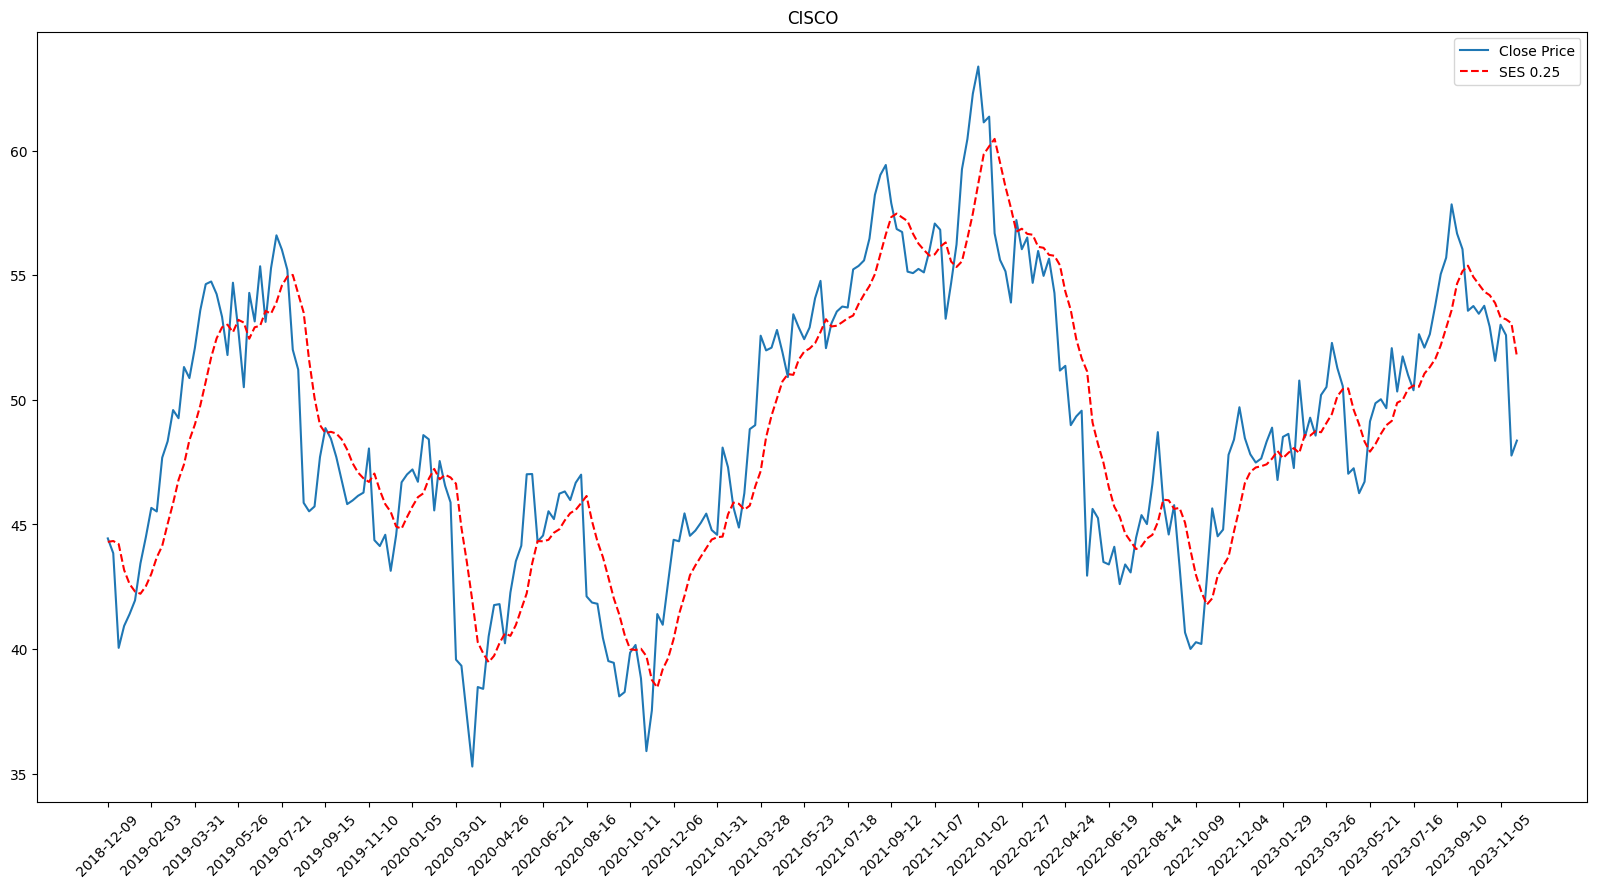

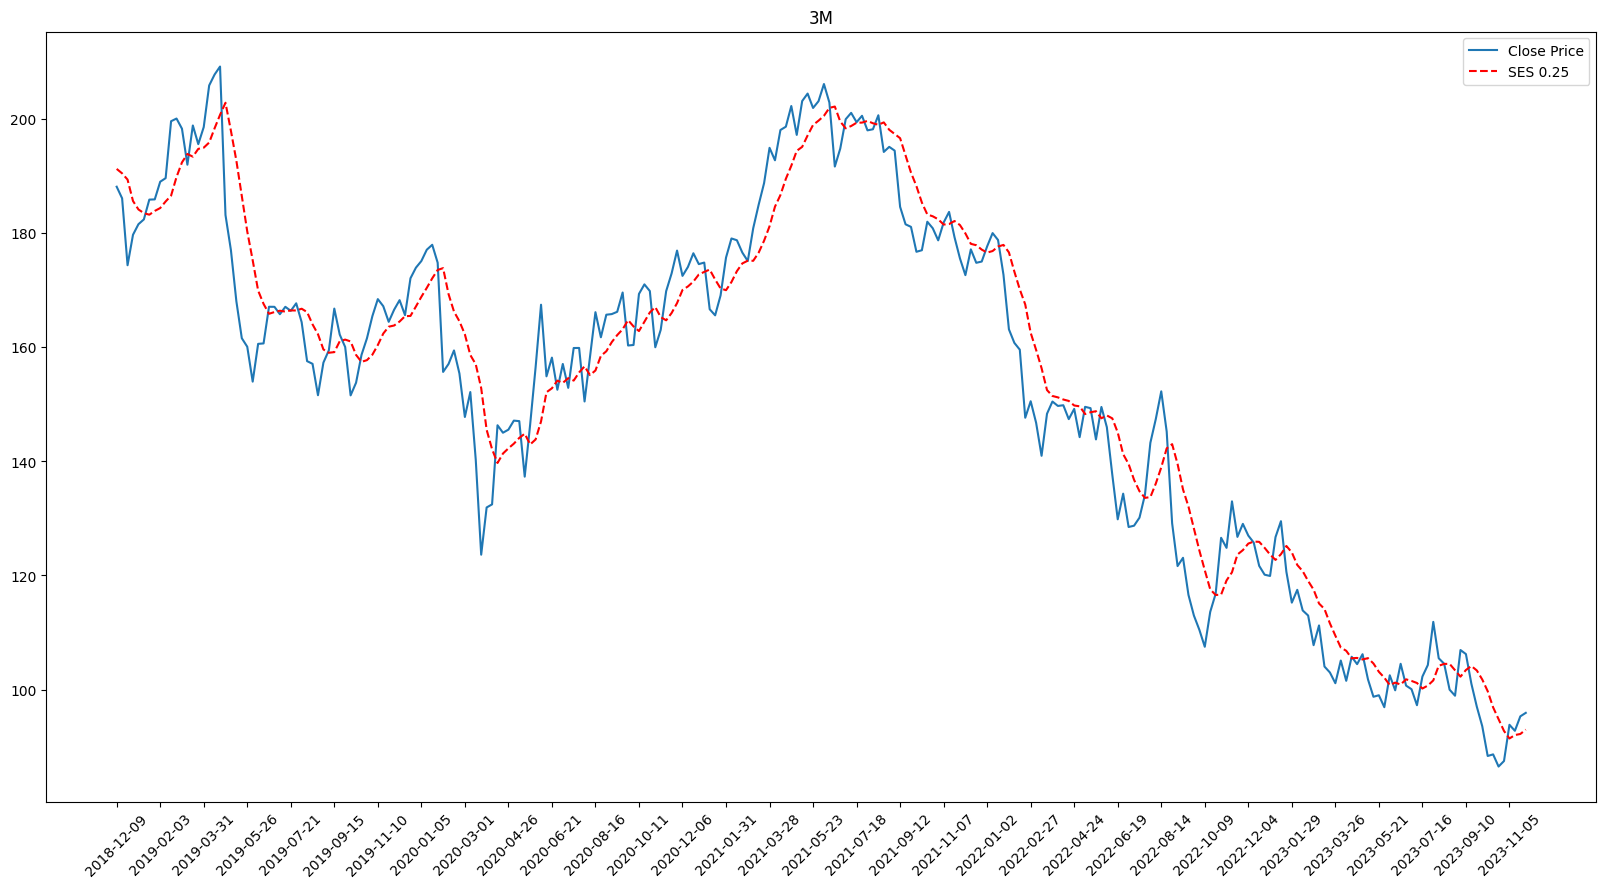

In [5]:
#exponential smoothing for each stock with alpha 0.25
for i in range(len(list_stocks)):
    model = SimpleExpSmoothing(list_stocks[i]['Close']).fit(smoothing_level=0.25)
    list_stocks[i]['SES'] = model.fittedvalues

#only the last 5 years
for i in range(len(list_stocks)):
    list_stocks[i] = list_stocks[i].iloc[-260:]

    
#plotting the exponential smoothing for each stock with alpha 0.25, reduce the plt to the last 5 years
for i in range(len(list_stocks)):
    plt.figure(figsize=(20, 10))

    plt.plot(list_stocks[i]['Date'], list_stocks[i]['Close'], label='Close Price')
    plt.plot(list_stocks[i]['Date'], list_stocks[i]['SES'], label='SES 0.25', color='red', linestyle='--')
    plt.title(list_series[i])
    dates = list_stocks[0]['Date']
    total_dates = len(dates)
    step = total_dates // 30     

    plt.xticks(dates[::step], rotation=45)
    plt.legend()
    plt.show()





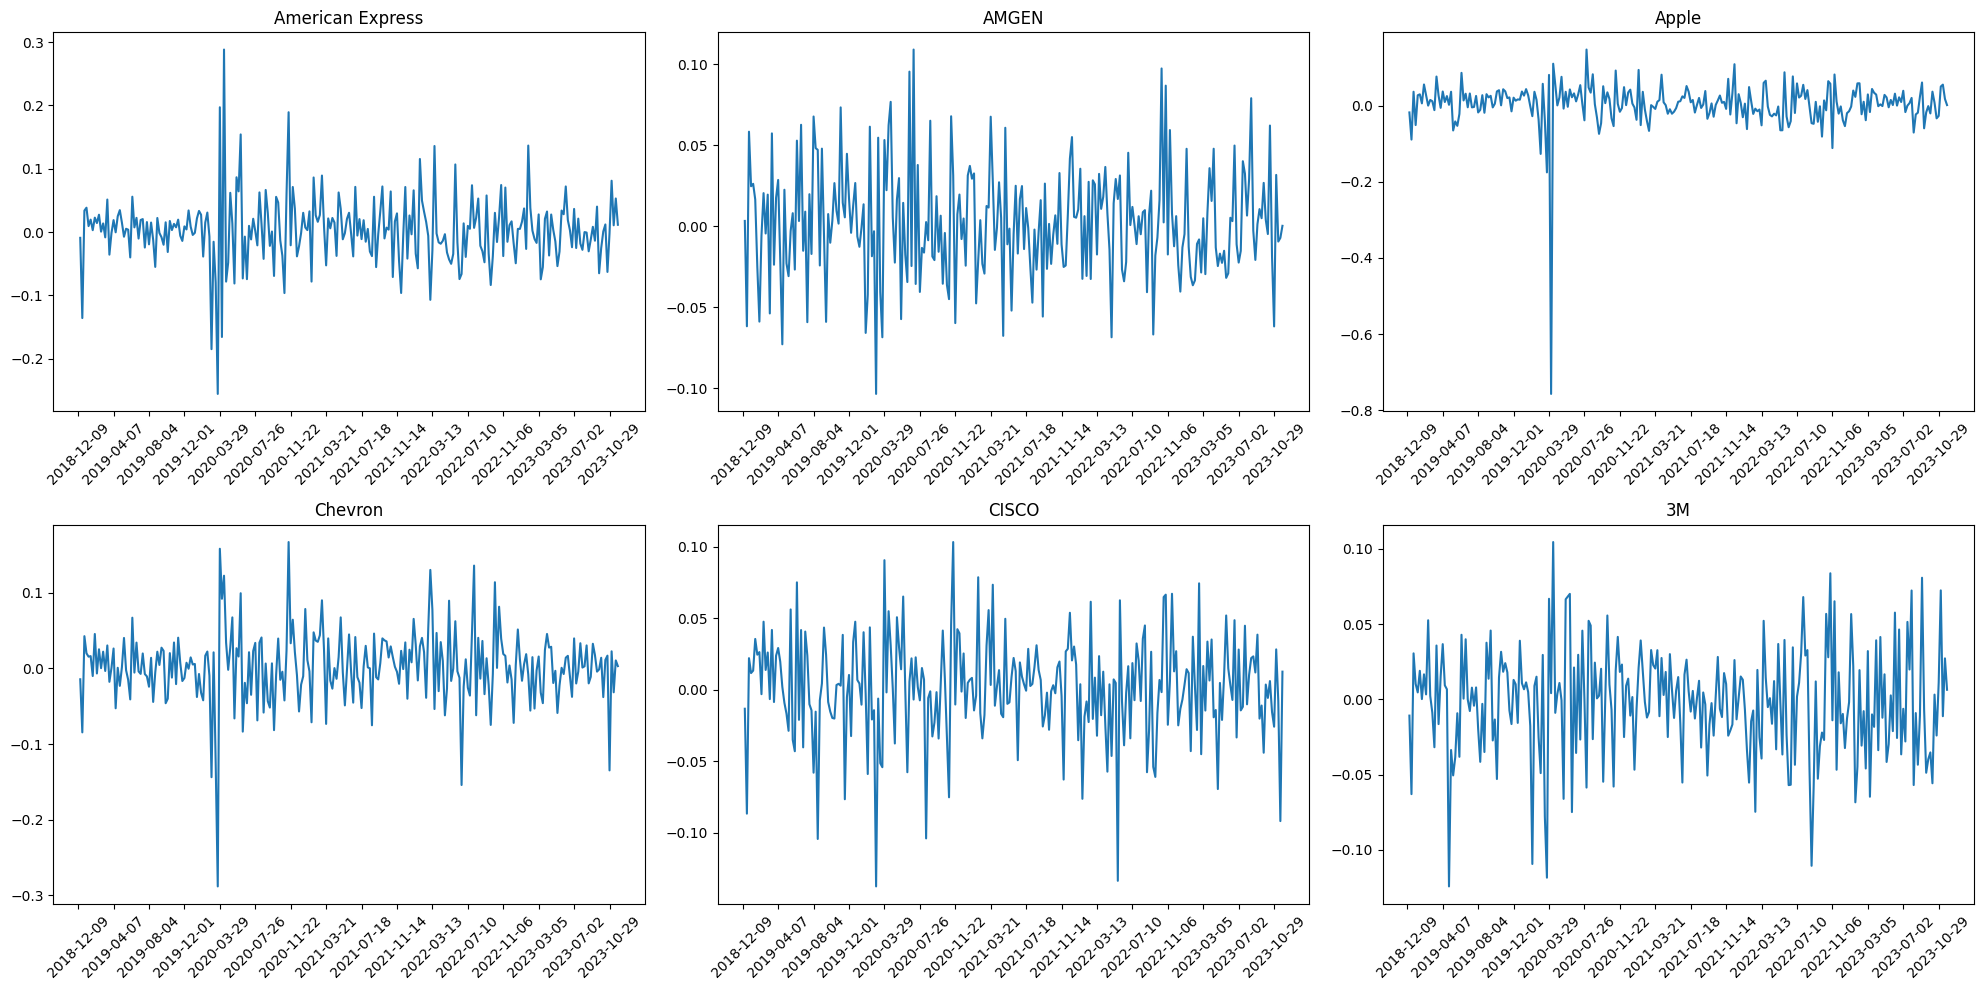

In [6]:
#find the percentage change of the close price for each stock
for i in range(len(list_stocks)):
    list_stocks[i]['Percentage Change'] = list_stocks[i]['Close'].pct_change()

#plotting the percentage change of the close price for each stock, make a layout of 2x3 plots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i in range(len(list_stocks)):
    axs[i].plot(list_stocks[i]['Date'], list_stocks[i]['Percentage Change'])
    axs[i].set_title(list_series[i])
    dates = list_stocks[0]['Date']
    total_dates = len(dates)
    step = total_dates // 15  
    axs[i].set_xticks(dates[::step])
    axs[i].set_xticklabels(dates[::step], rotation=45)

plt.tight_layout()
plt.show()




/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

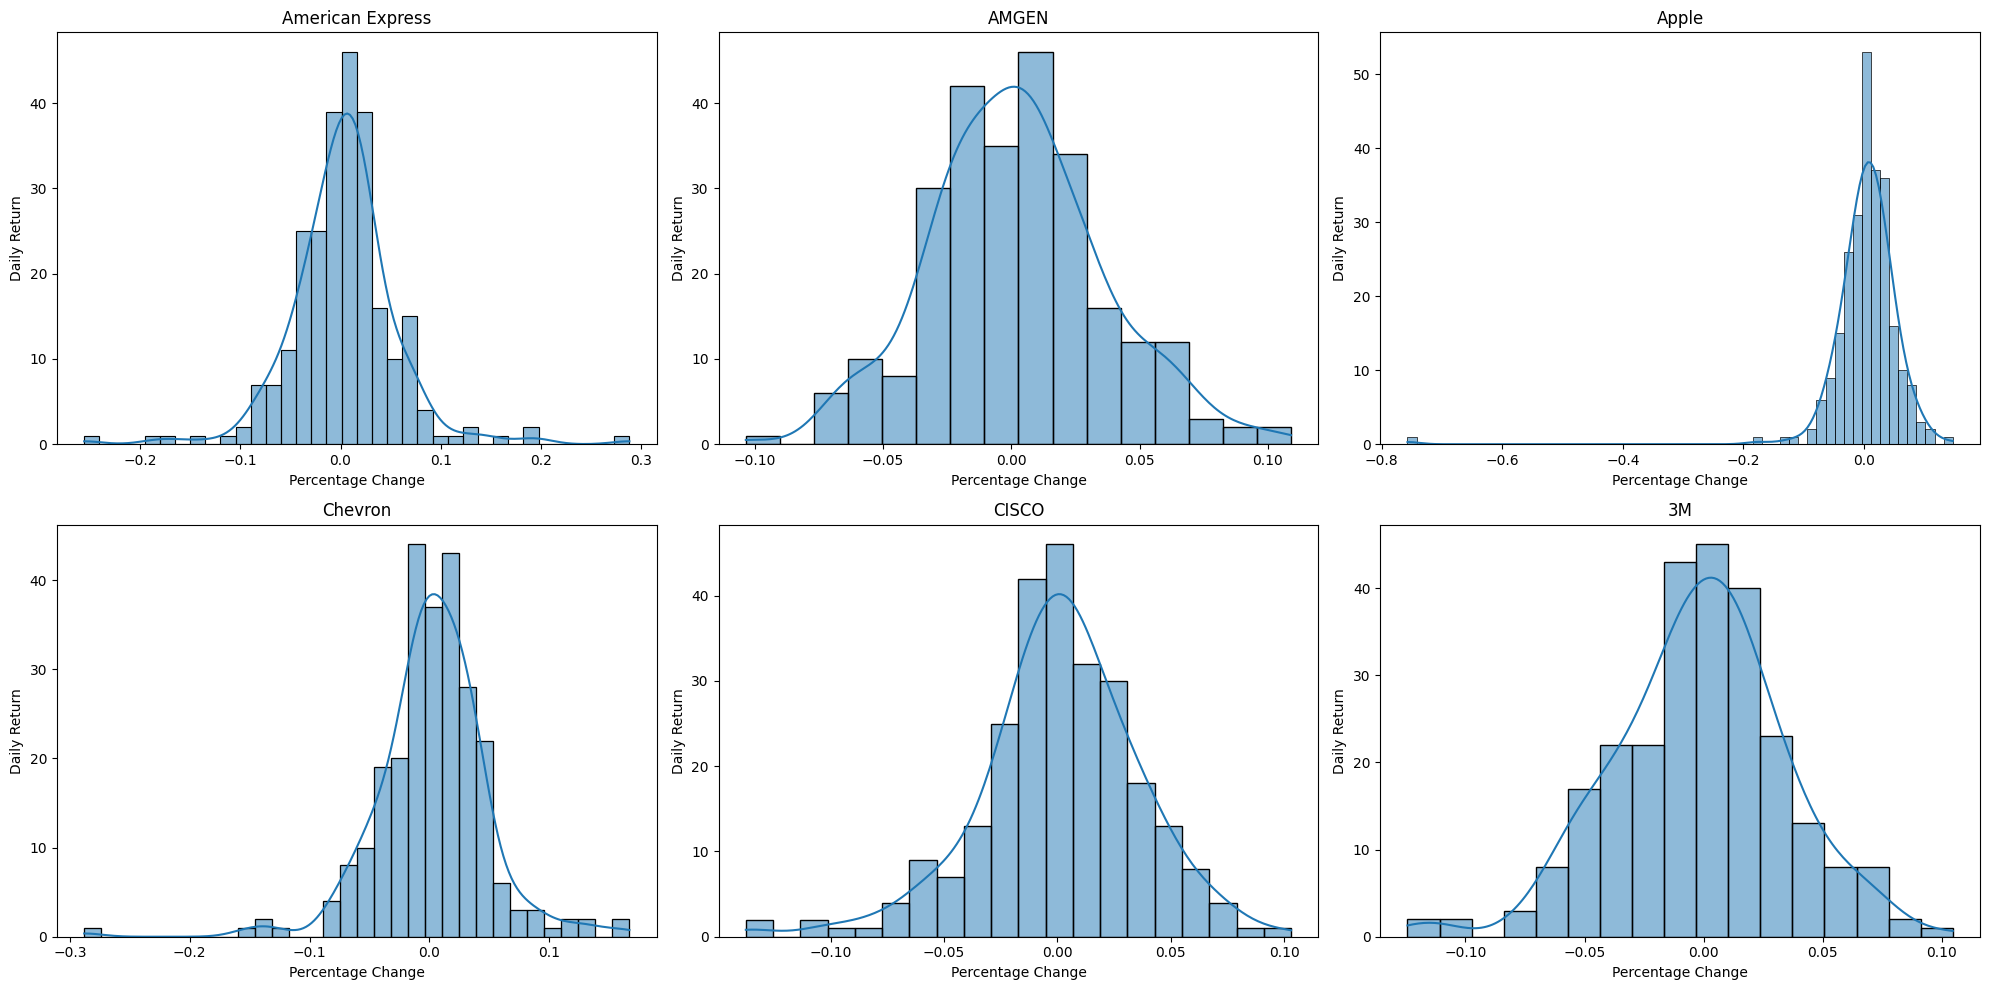

In [7]:
#percent change of daily returns but using distplot() from seaborn package, put 'Daily Return {name stock}' as y-title, plot alsoa  line of the mean of the percentage change
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i in range(len(list_stocks)):
    sns.histplot(list_stocks[i]['Percentage Change'], ax=axs[i], kde=True)
    axs[i].set_title(list_series[i])
    axs[i].set_ylabel(f'Daily Return')
plt.tight_layout()
plt.show()



/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alessandro_iva/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

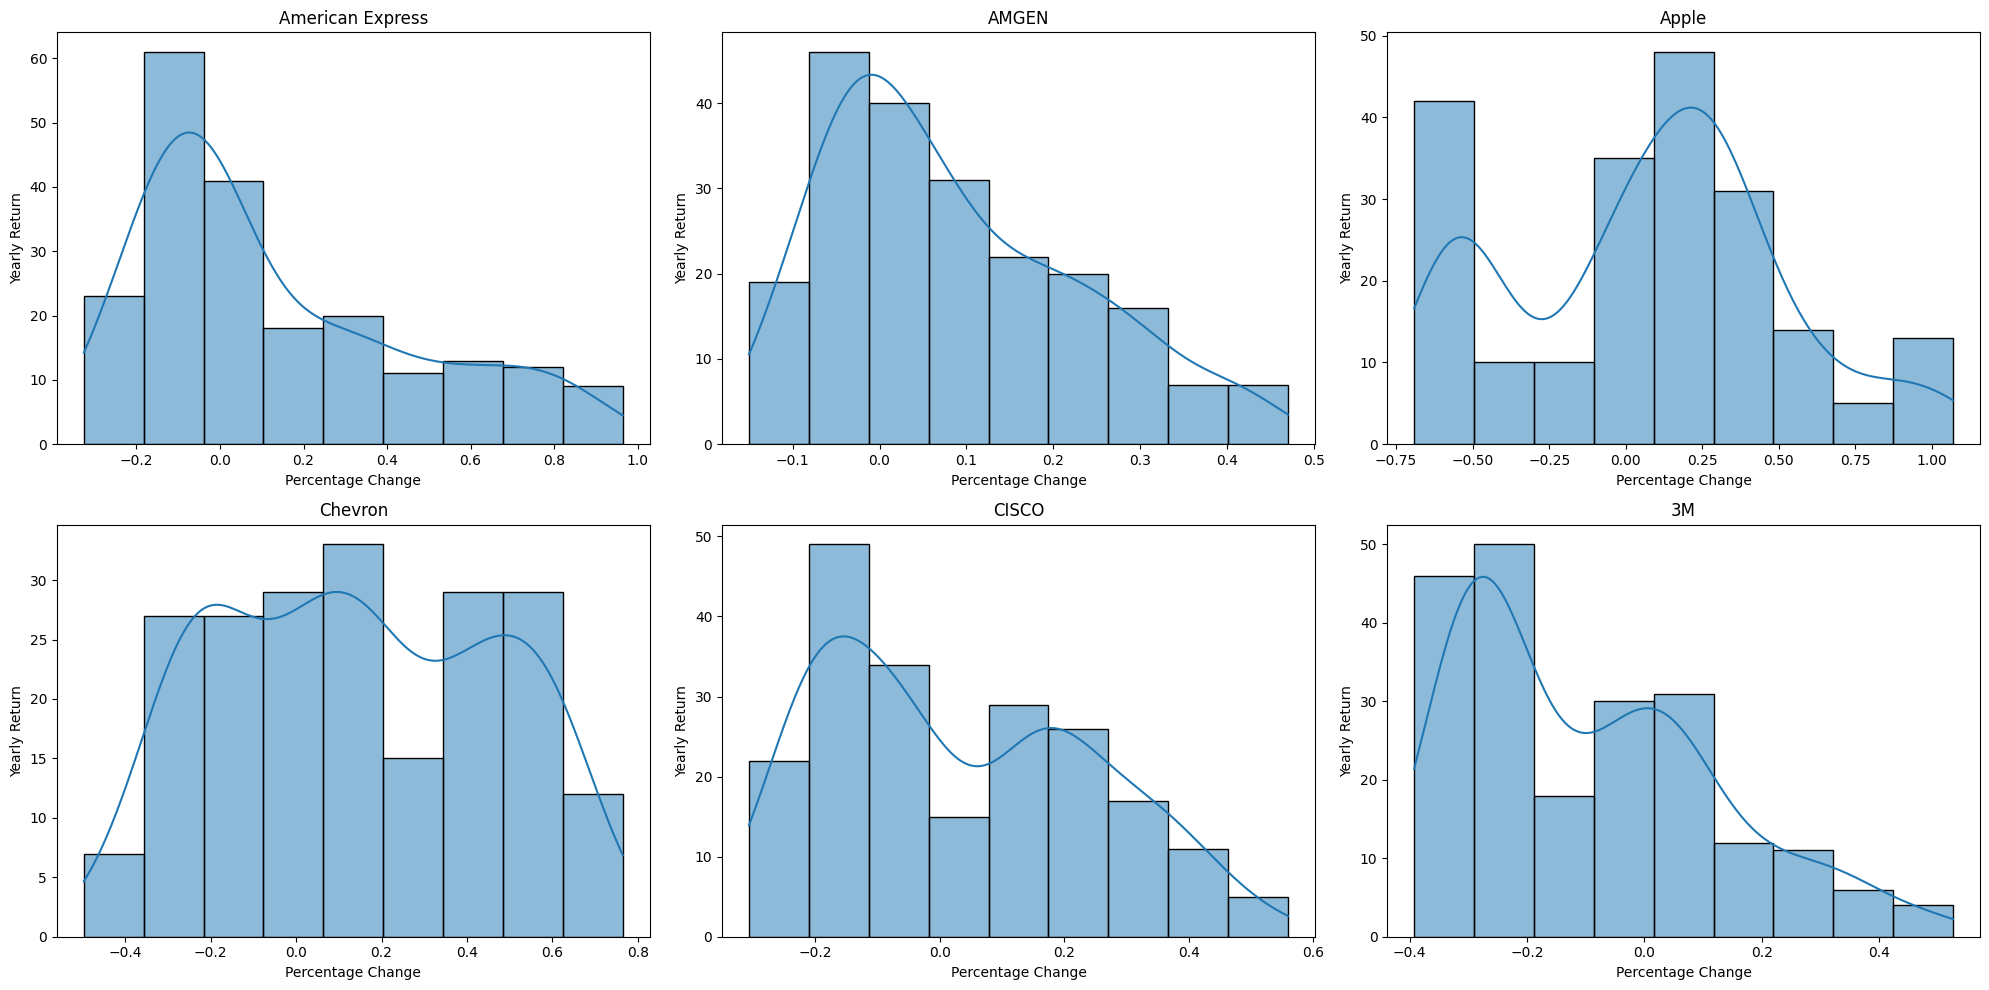

In [12]:
#percentage change of yearly returns but using distplot() from seaborn package, put 'Daily Return {name stock}' as y-title, plot alsoa  line of the mean of the percentage change
for i in range(len(list_stocks)):
    list_stocks[i]['Year'] = pd.DatetimeIndex(list_stocks[i]['Date']).year
    list_stocks[i]['Yearly Return'] = list_stocks[i]['Close'].pct_change(52)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i in range(len(list_stocks)):
    sns.histplot(list_stocks[i]['Yearly Return'], ax=axs[i], kde=True)
    axs[i].set_title(list_series[i])
    axs[i].set_ylabel(f'Yearly Return')
    axs[i].set_xlabel(f'Percentage Change')
plt.tight_layout()
plt.show()

In [9]:
#risk analysis of the stocks, calculate the standard deviation of the percentage change of the close price for each stock
for i in range(len(list_stocks)):
    std = list_stocks[i]['Percentage Change'].std()
    print(f"Stock: {list_series[i]}")
    print(f"Standard Deviation: {std}")
    print(f"Annualized Standard Deviation: {std * np.sqrt(52)}")
    print(f"Annualized Volatility: {std * np.sqrt(52) * 100:.2f}%")
    print()
    


Stock: American Express
Standard Deviation: 0.05369553972747453
Annualized Standard Deviation: 0.3872040435022462
Annualized Volatility: 38.72%

Stock: AMGEN
Standard Deviation: 0.034081380017741816
Annualized Standard Deviation: 0.24576432638508383
Annualized Volatility: 24.58%

Stock: Apple
Standard Deviation: 0.06227593919401163
Annualized Standard Deviation: 0.4490781839833729
Annualized Volatility: 44.91%

Stock: Chevron
Standard Deviation: 0.04750449694995649
Annualized Standard Deviation: 0.34255979913638157
Annualized Volatility: 34.26%

Stock: CISCO
Standard Deviation: 0.035665859977194805
Annualized Standard Deviation: 0.2571901738625895
Annualized Volatility: 25.72%

Stock: 3M
Standard Deviation: 0.03608507405651217
Annualized Standard Deviation: 0.26021316957933993
Annualized Volatility: 26.02%

